# Electric Vehicle Charging Demand
---
This notebook runs an LCOE-optimized wind/solar/storage plant in Boulder, CO based on a load following schedule representing an hourly EV load demand. The EV demand was generated using EVI-Pro (Lite).

### Import Required Modules
Begin by importing the necessary modules for the simulation.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from hopp import ROOT_DIR
from hopp.simulation import HoppInterface
from hopp.utilities import load_yaml
from hopp.simulation.technologies.sites import SiteInfo, flatirons_site
from hopp.tools.dispatch.plot_tools import (
    plot_battery_output, plot_battery_dispatch_error, plot_generation_profile
)

/Users/cirmas/workspace/HOPP/ev/notebooks/log/hybrid_systems_2023-12-28T15.26.30.010468.log


In [2]:
sns.set_theme()

### Set Site Information
Set wind and solar resource data at plant location and load pricing data. In this example, we use the Flatirons site as an example location.

**NOTE**: For a load following objective function the `desired_schedule` must be set.

In [3]:
ev_load = pd.read_csv("../data/boulder_demand_evi.csv", header=None)

In [4]:
periods = 24*7
dates = pd.date_range(start="2022-01-01", periods=periods, freq="H")

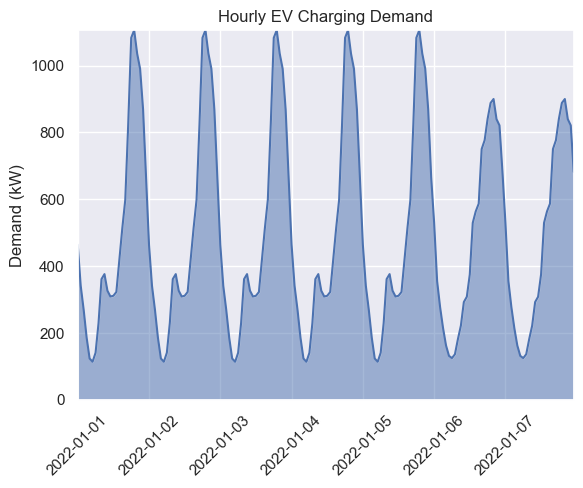

In [5]:
fig, ax = plt.subplots()
periods = 24*7
load = ev_load.iloc[:periods, 0]

ax.plot(dates, load)
ax.fill_between(dates, 0, load, alpha=0.5)

ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45)

ax.set_title("Hourly EV Charging Demand")
ax.set_ylabel("Demand (kW)")
ax.set_xmargin(0)
ax.set_ymargin(0)

In [6]:
DEFAULT_SOLAR_RESOURCE_FILE = ROOT_DIR.parent / "resource_files" / "solar" / "35.2018863_-101.945027_psmv3_60_2012.csv"
DEFAULT_WIND_RESOURCE_FILE = ROOT_DIR.parent / "resource_files" / "wind" / "35.2018863_-101.945027_windtoolkit_2012_60min_80m_100m.srw"
DEFAULT_PRICE_FILE = ROOT_DIR.parent / "resource_files" / "grid" / "pricing-data-2015-IronMtn-002_factors.csv"

site = SiteInfo(
        flatirons_site,
        solar_resource_file=DEFAULT_SOLAR_RESOURCE_FILE,
        wind_resource_file=DEFAULT_WIND_RESOURCE_FILE,
        grid_resource_file=DEFAULT_PRICE_FILE,
        desired_schedule=ev_load.iloc[:, 0].values / 1000, # MW
        solar=True,
        wind=True,
        wave=False
    )

### Create the HOPP Model
To generate the HOPP Model, instantiate the `HoppInterface` class and supply the required YAML configuration.

`HOPPInterface` is capable of handling dictionary input as well as class instances. Here we demonstrate this by loading the YAML file as a dict, modifying it to include our site information, then passing it as an argument to `HoppInterface`. This is useful for programmatic configuration of simulation configs.

In [7]:
hopp_config = load_yaml("../inputs/ev-load-following-battery.yaml")
# set SiteInfo instance
hopp_config["site"] = site

hopp_config["technologies"]["pv"]["system_capacity_kw"] = 621.76824284
hopp_config["technologies"]["wind"]["turbine_rating_kw"] = 813.20351766
hopp_config["technologies"]["battery"]["system_capacity_kw"] = 375.36999667
hopp_config["technologies"]["battery"]["system_capacity_kwh"] = 3378.3299385

### Create the Simulation Model
Instantiate the `HoppInterface` class by providing our modified configuration dict.

In [8]:
hi = HoppInterface(hopp_config)

### Run the Simulation

In [9]:
hi.simulate()

### Print Simulation Results
Access and display various simulation results, including annual energies, net present values (NPVs), and total revenues.

In [10]:
hybrid_plant = hi.system

# print("Output after losses over gross output:",
      # hybrid_plant.wind.value("annual_energy") / hybrid_plant.wind.value("annual_gross_energy"))

# Save the outputs
annual_energies = hybrid_plant.annual_energies
npvs = hybrid_plant.net_present_values
revs = hybrid_plant.total_revenues

print("Annual Energies:")
print(annual_energies)

print("Net Present Values:")
print(npvs)

print("Total Revenues:")
print(revs)

Annual Energies:
{"pv": 1296969.8922468845, "wind": 2663163.881104323, "battery": -6372.790273757281, "hybrid": 3239922.4754619747}
Net Present Values:
{"pv": 547146.9223592378, "wind": 1267330.3067240822, "battery": -624677.2106427733, "hybrid": 603343.161763473}
Total Revenues:
{"pv": [0.0, 125655.50898101379, 126912.06407082392, 128181.18471153217, 129462.99655864749, 130757.62652423396, 132065.20278947635, 133385.8548173711, 134719.71336554477, 136066.91049920022, 137427.57960419223, 138801.85540023414, 140189.87395423648, 141591.77269377888, 143007.69042071665, 144437.76732492386, 145882.14499817305, 147340.96644815482, 148814.37611263632, 150302.5198737627, 151805.5450725003, 153323.60052322535, 154856.8365284576, 156405.40489374218, 157969.45894267957, 159549.1535321064], "wind": [0.0, 261843.77353736735, 264462.211272741, 267106.83338546846, 269777.9017193231, 272475.6807365163, 275200.4375438816, 277952.4419193204, 280731.96633851354, 283539.2860018987, 286374.6788619177, 2892

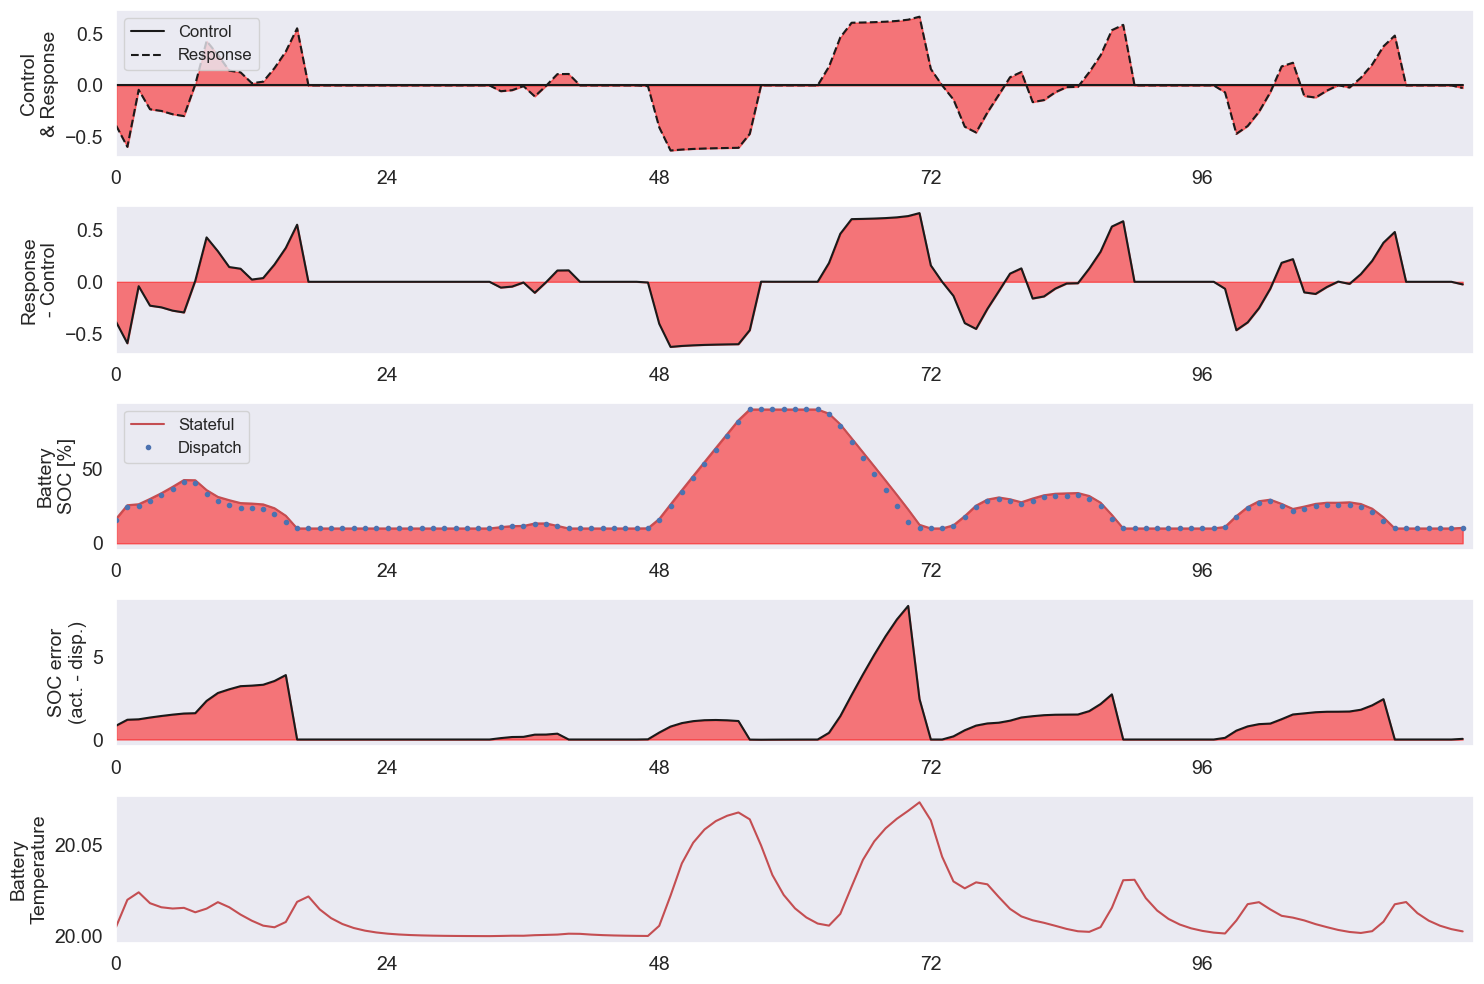

In [11]:
plot_battery_output(hybrid_plant)

In [12]:
#plot_battery_dispatch_error(hybrid_plant)

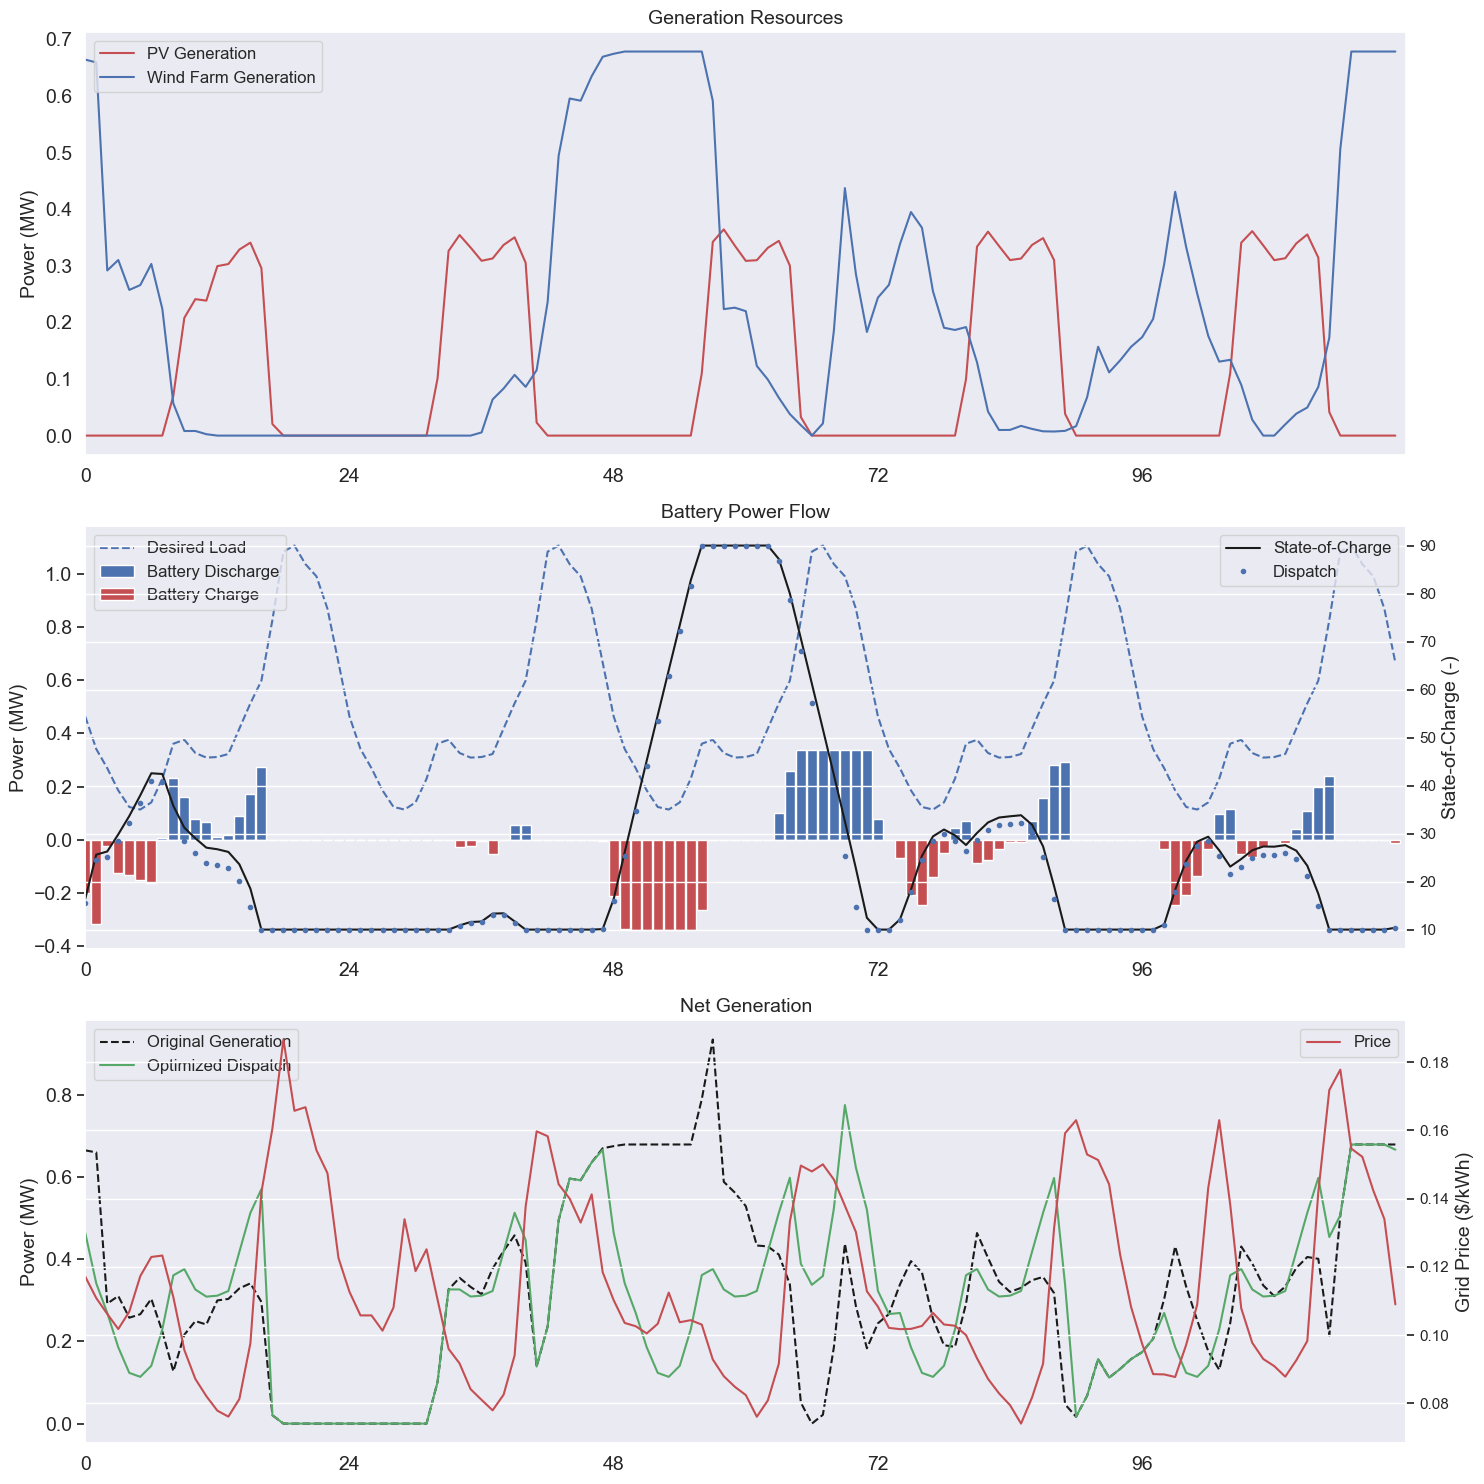

In [13]:
plot_generation_profile(hybrid_plant)

In [14]:
hybrid_plant.grid.missed_load_percentage

0.25000012214711204

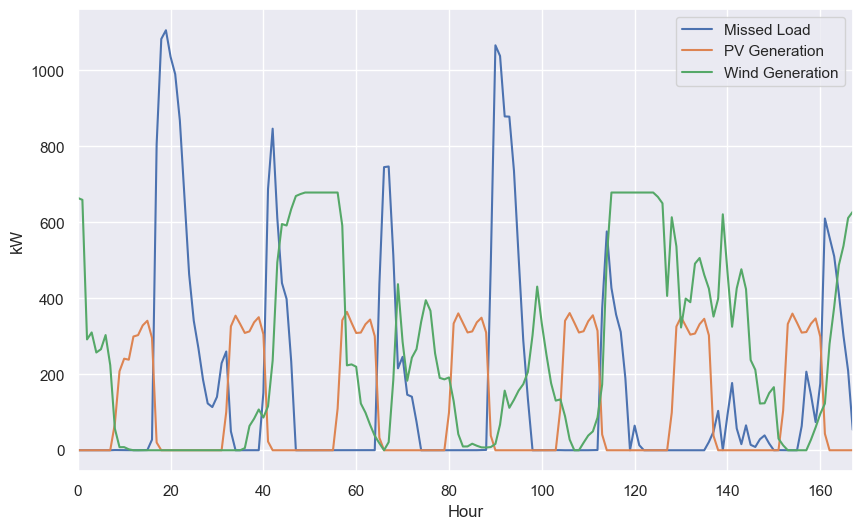

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(np.arange(24*7), hybrid_plant.grid.missed_load[:24*7], label="Missed Load")
ax.plot(np.arange(24*7), hybrid_plant.pv.generation_profile[:24*7], label="PV Generation")
ax.plot(np.arange(24*7), hybrid_plant.wind.generation_profile[:24*7], label="Wind Generation")

ax.set_xmargin(0)
ax.set_xlabel("Hour")
ax.set_ylabel("kW")
ax.legend()

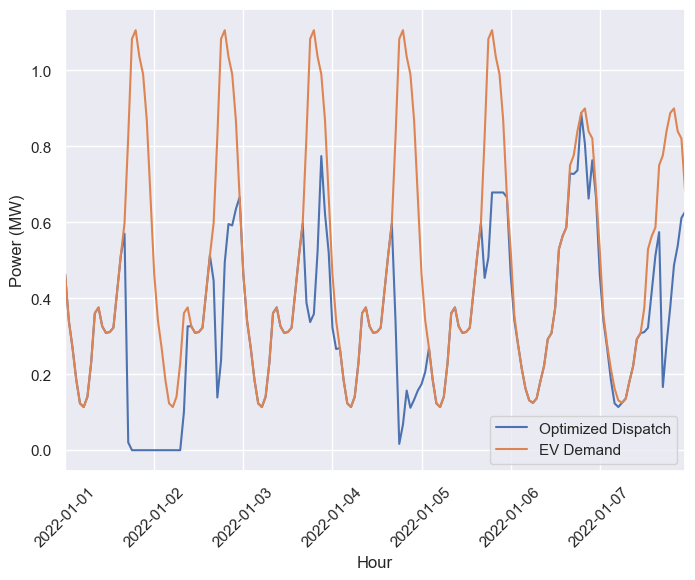

In [16]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(8, 6))

x = np.arange(8760)
y = np.array(hybrid_plant.grid.generation_profile) / 1000

# ax.plot(dates, hybrid_plant.grid.missed_load[:periods], label="Missed Load")
# ax.plot(dates, hybrid_plant.pv.generation_profile[:periods], label="PV Generation")
# ax.plot(dates, hybrid_plant.wind.generation_profile[:periods], label="Wind Generation")
ax.plot(dates, y[:periods], label="Optimized Dispatch")
ax.plot(dates, ev_load[:periods] / 1000, label="EV Demand")

ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45)
        
ax.set_xlabel("Hour")
ax.set_ylabel("Power (MW)")
ax.set_xmargin(0)

ax.legend()